## Initial Setup

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Filter out warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [5]:
# Load the dataset
data = pd.read_csv('Data_Cortex_Nuclear.csv')

# Replace infinities with NaN
def replace_infinities(data):
    return data.replace([np.inf, -np.inf], np.nan)
data = replace_infinities(data)

## Data Exploration

### Imbalance in the Target Variable

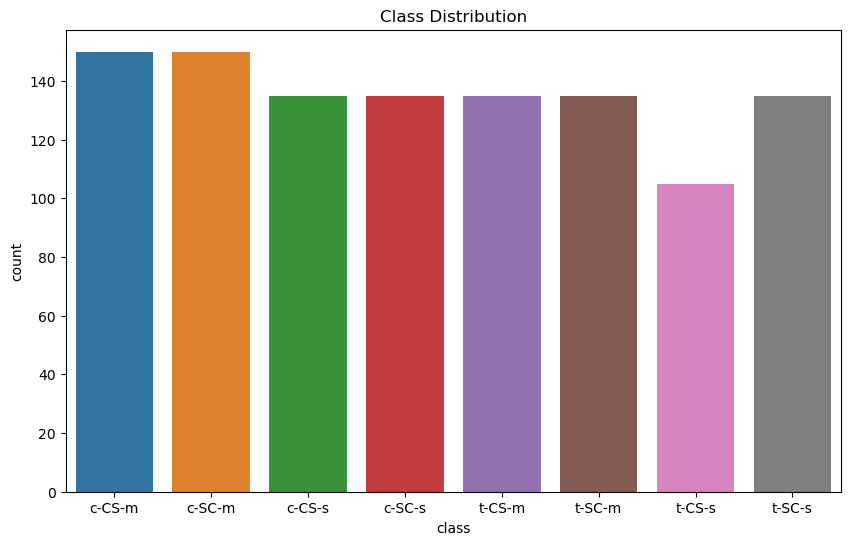

In [8]:
# Plotting the count of each class in the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='class')
plt.title('Class Distribution')
plt.show()

### Correlation Plots for Subsamples

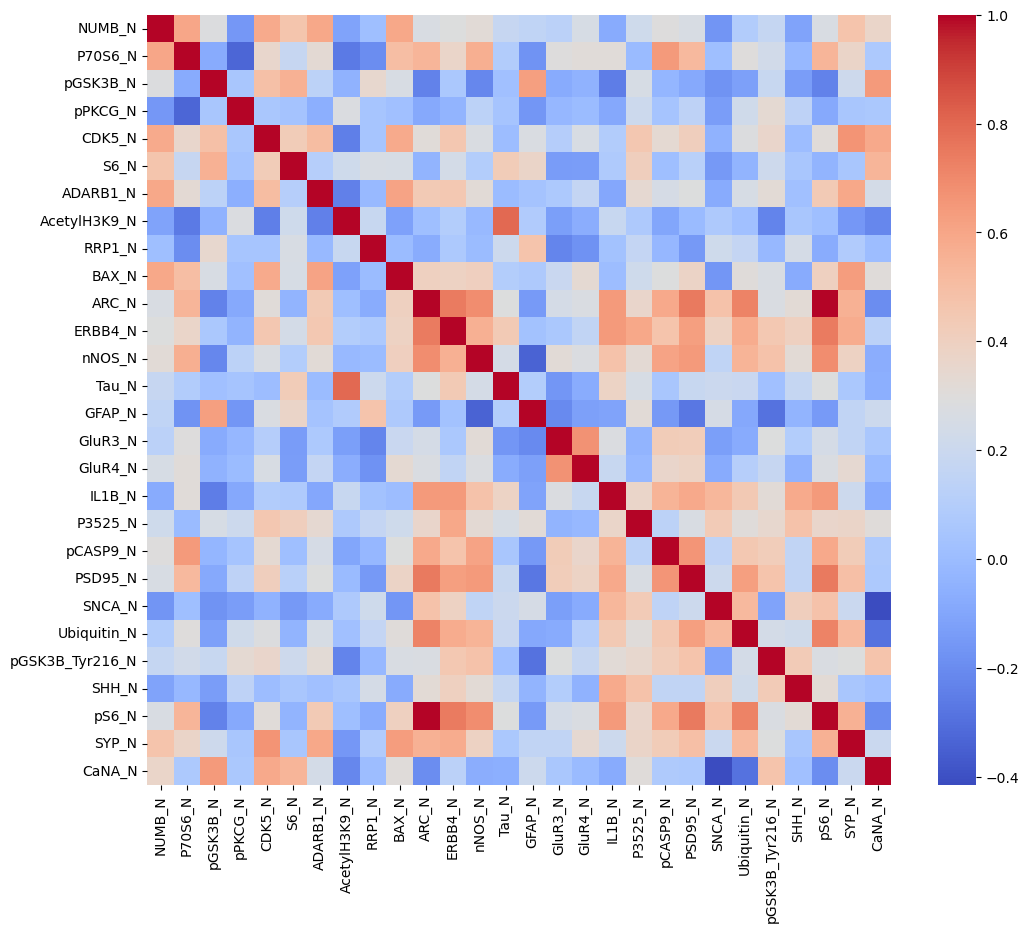

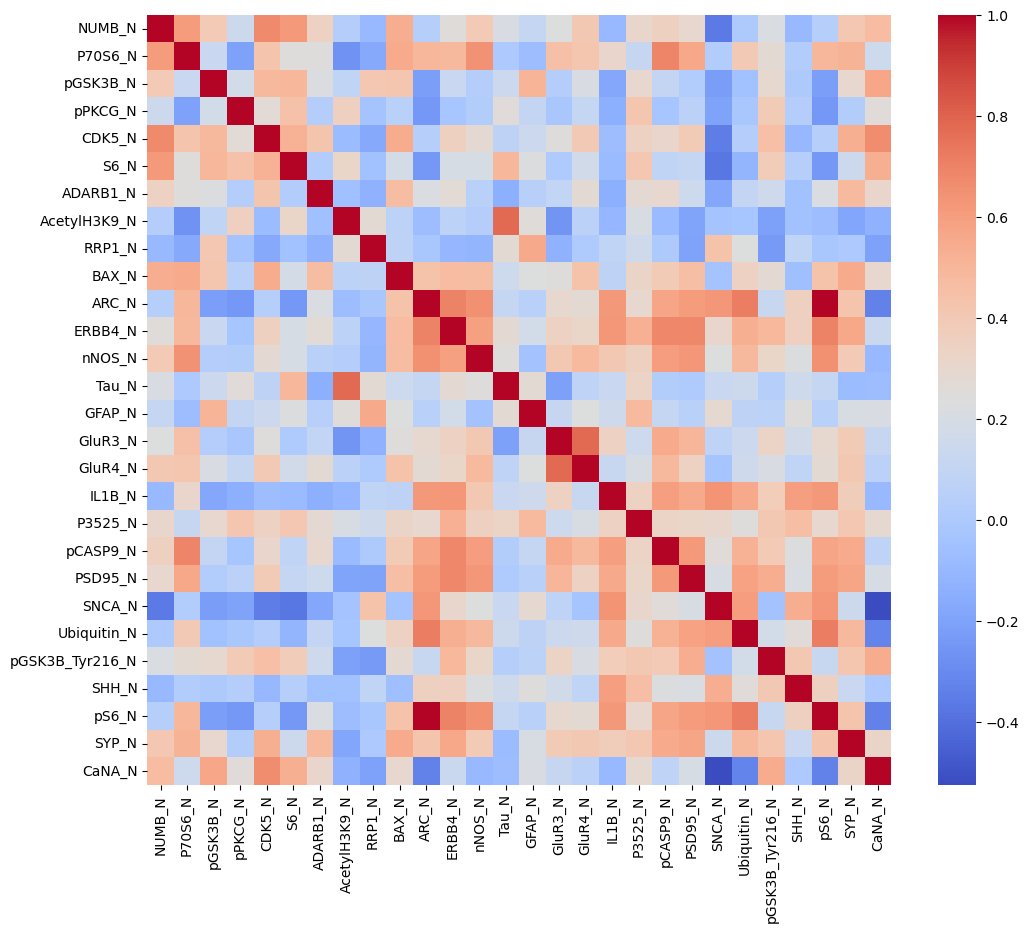

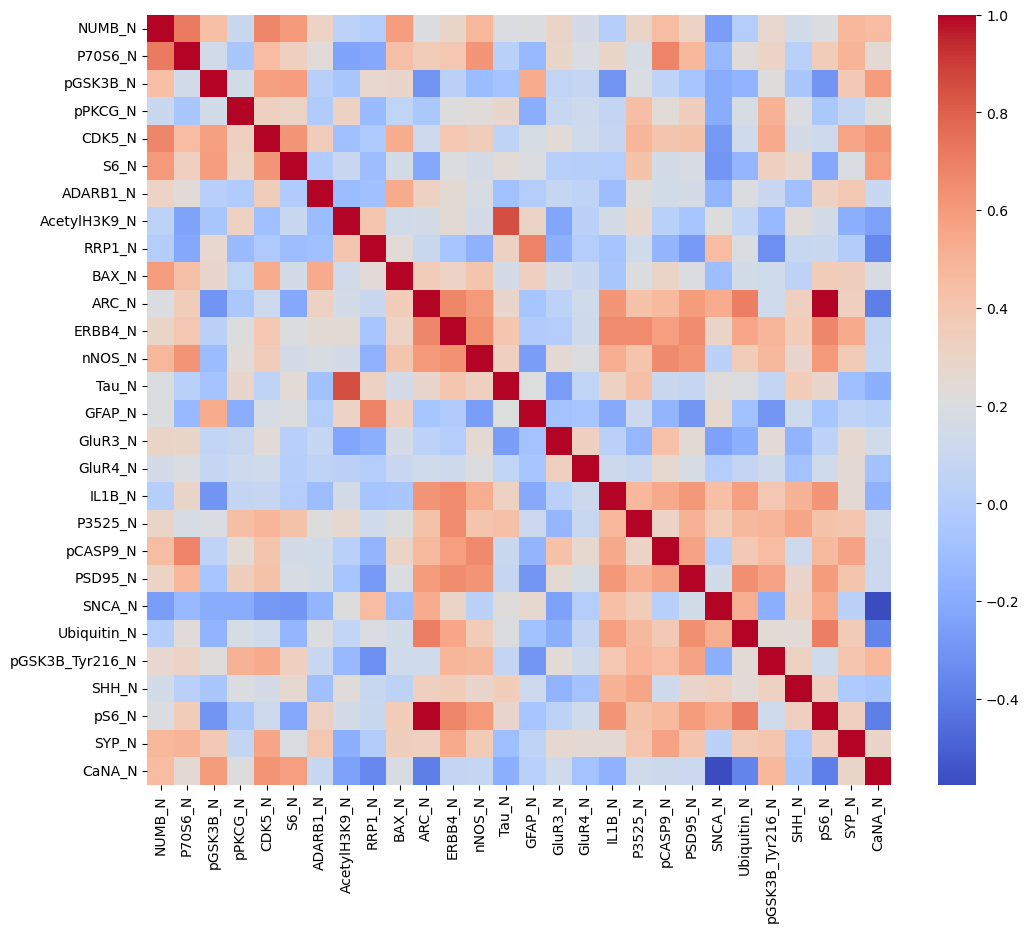

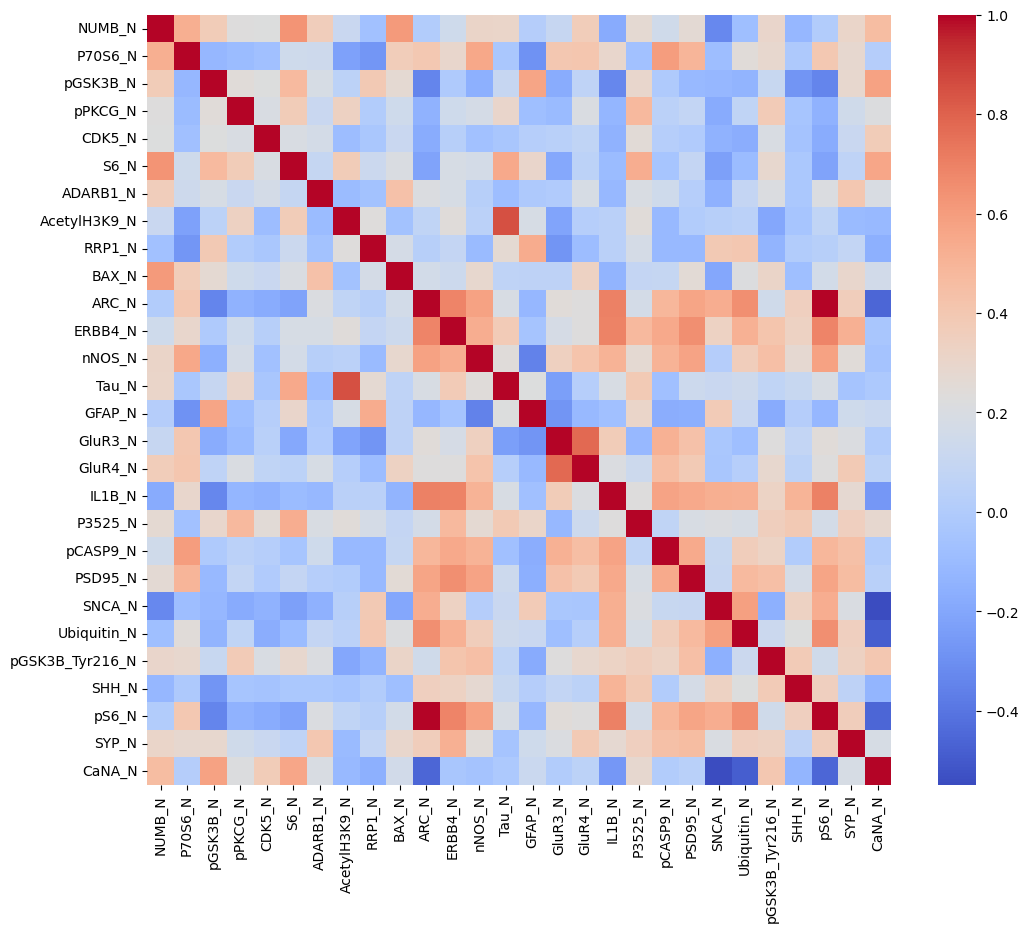

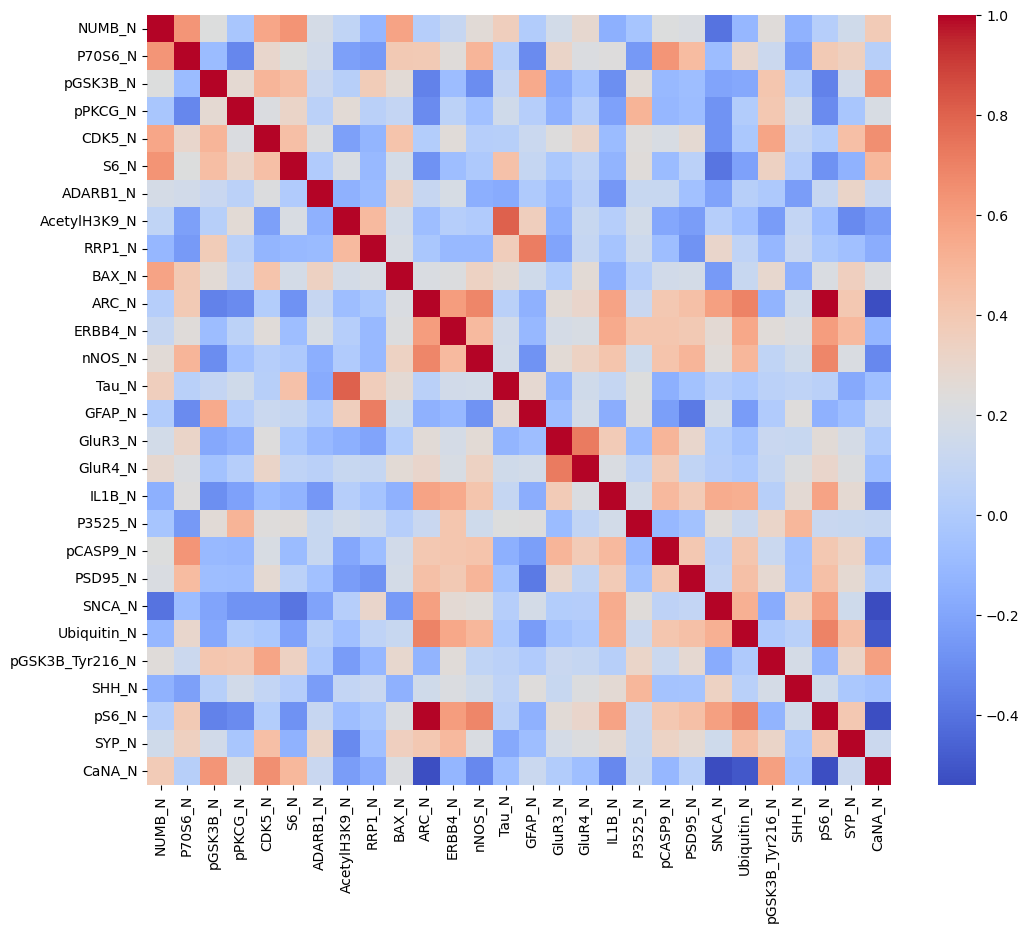

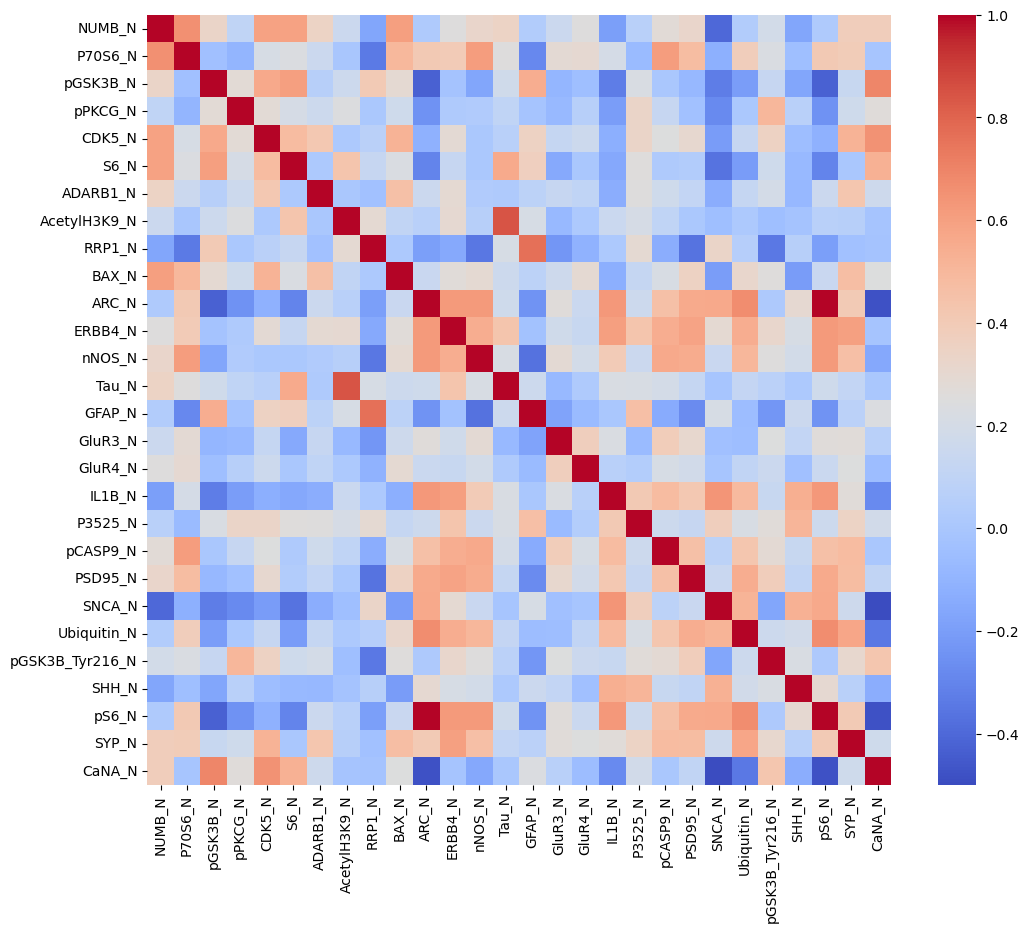

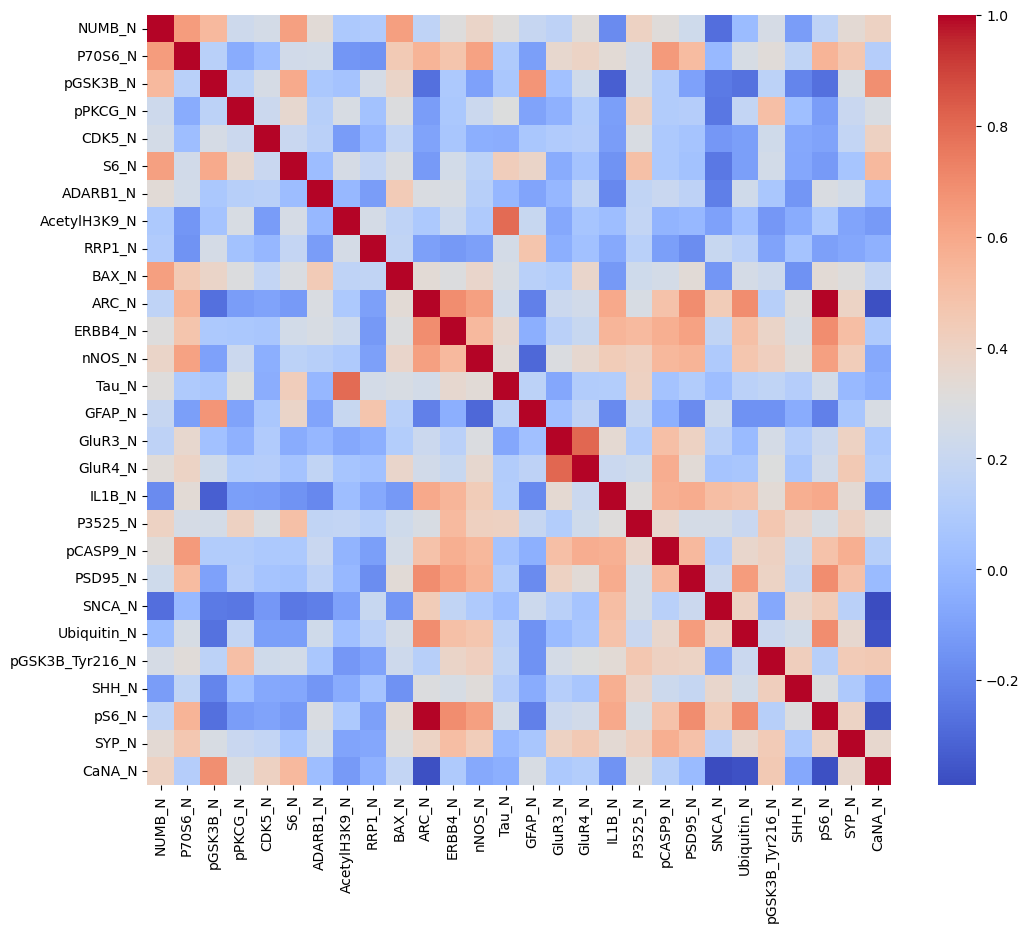

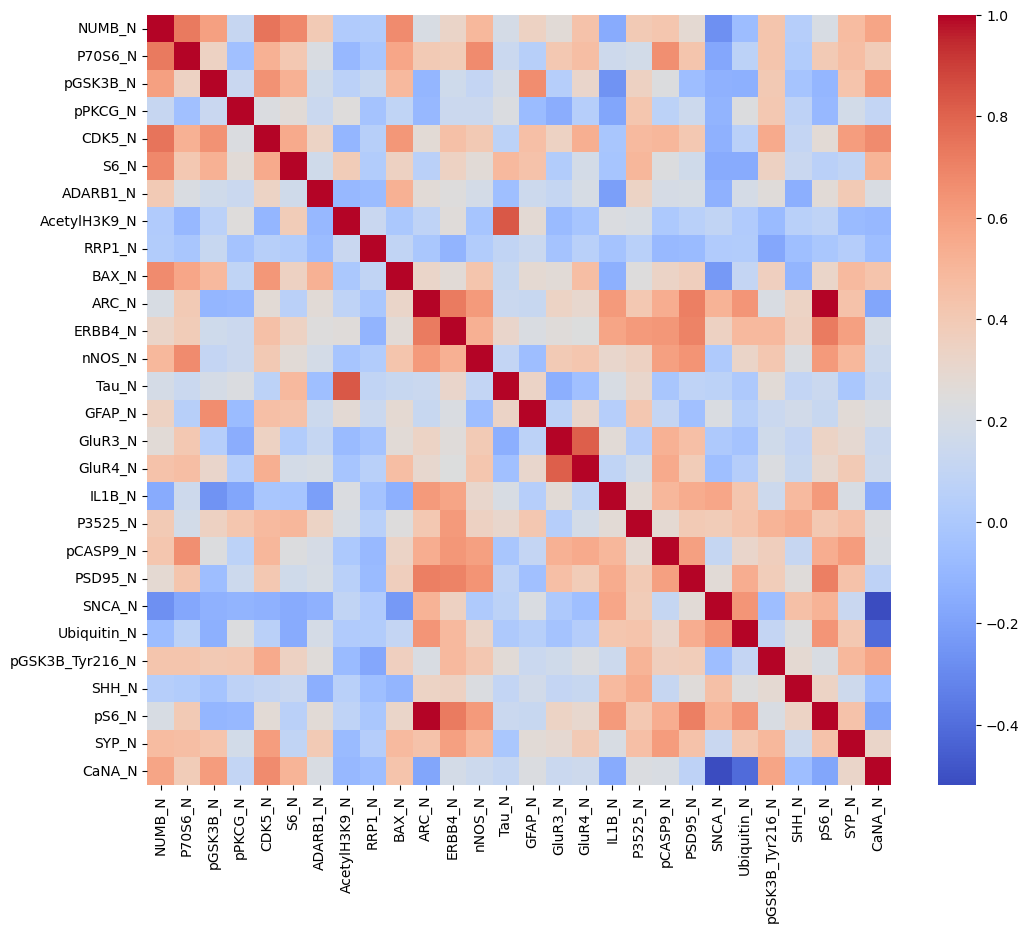

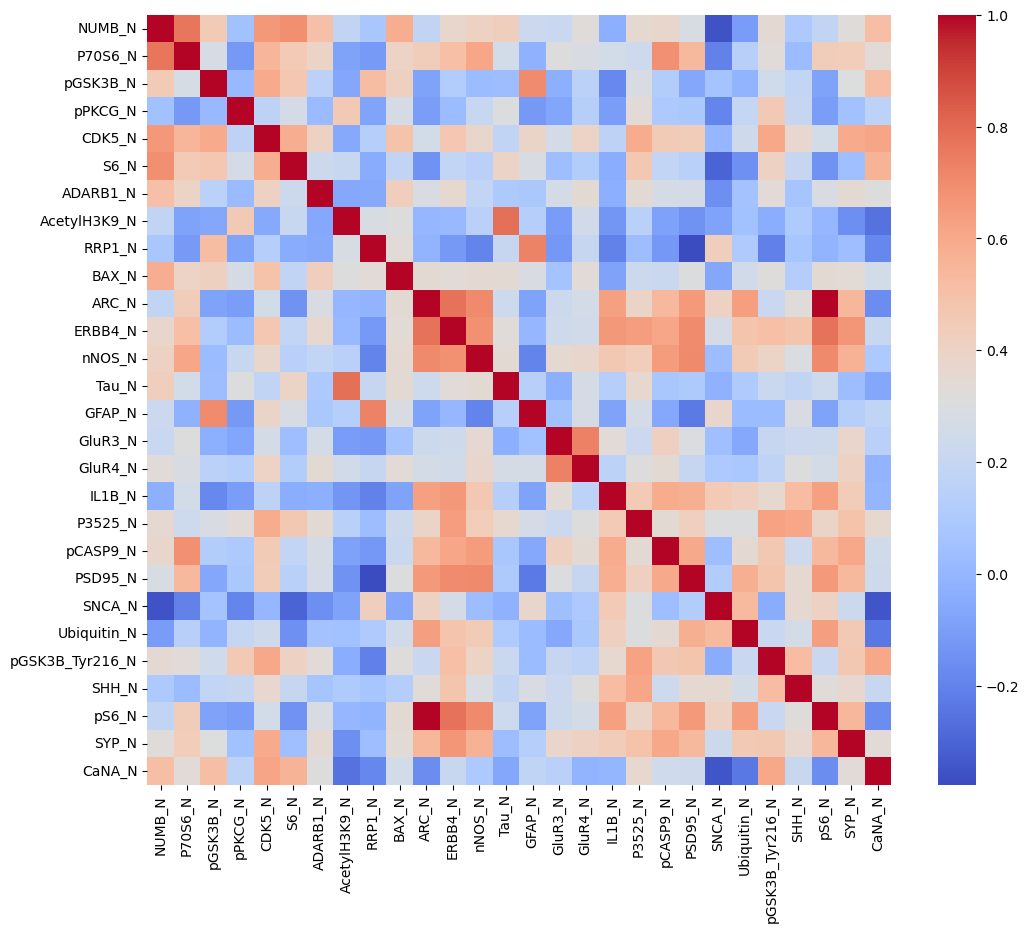

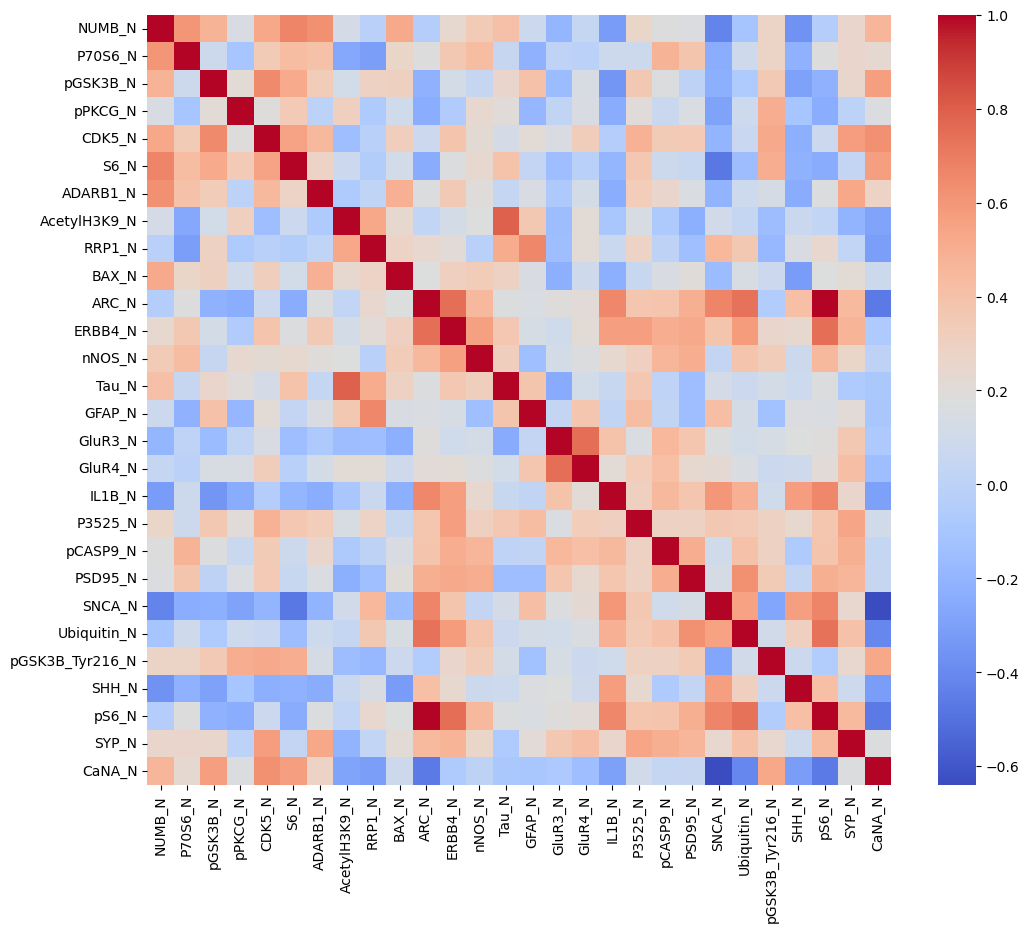

In [10]:
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible values to NaN
data_numeric = data.apply(pd.to_numeric, errors='coerce')

# Check and drop columns with any NaN values
data_numeric = data_numeric.dropna(axis=1)

# Function to plot correlation matrix
def plot_correlation(df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), fmt='.2f', cmap='coolwarm')
    plt.show()

# Taking 10 random subsamples and plotting their correlation matrices
for i in range(10):
    subsample = data_numeric.sample(n=100)  # assuming 'moderately sized' means 100 samples
    plot_correlation(subsample)

### Pairplot of Feature Variables for Subsamples

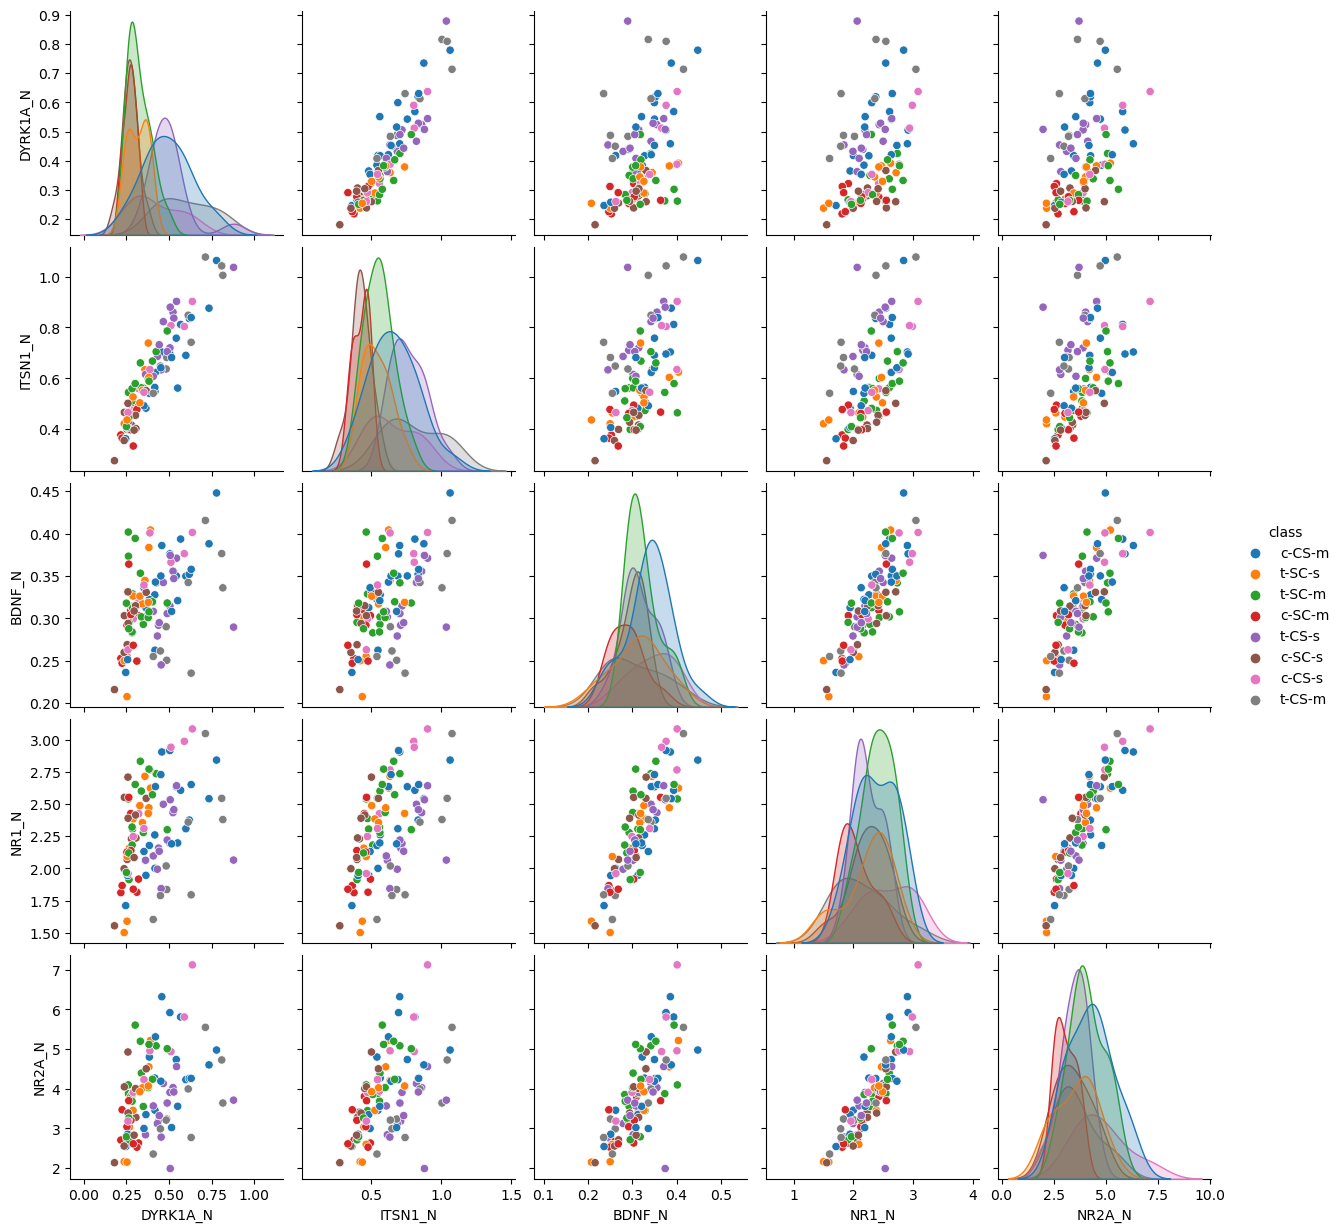

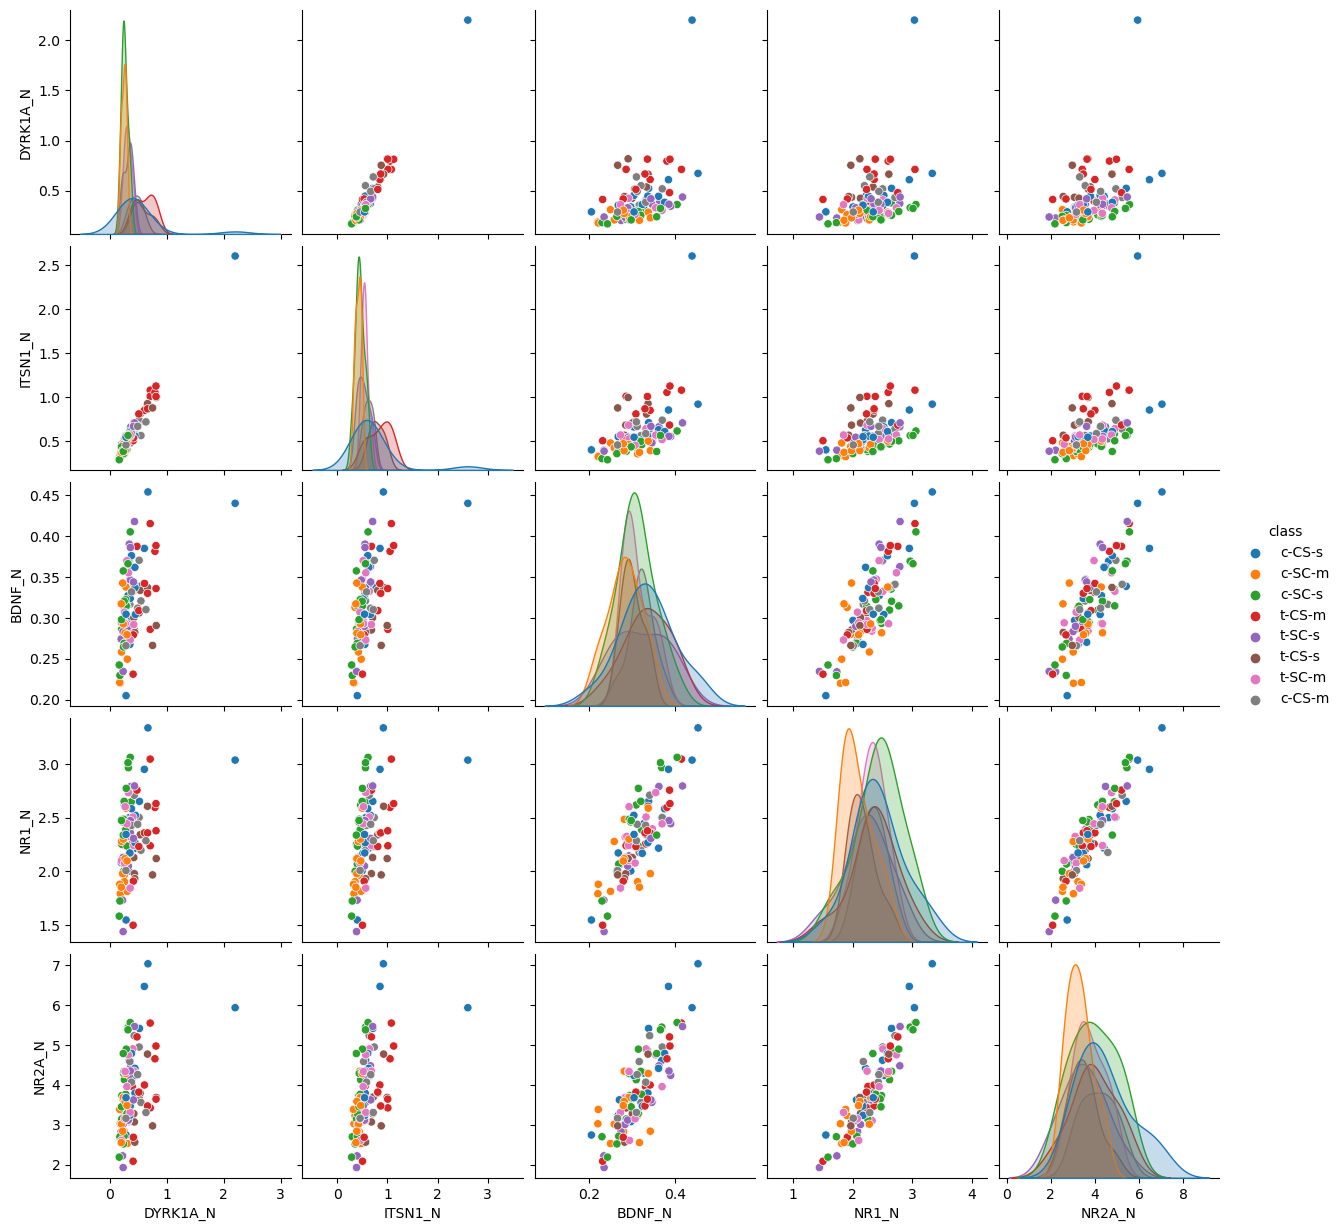

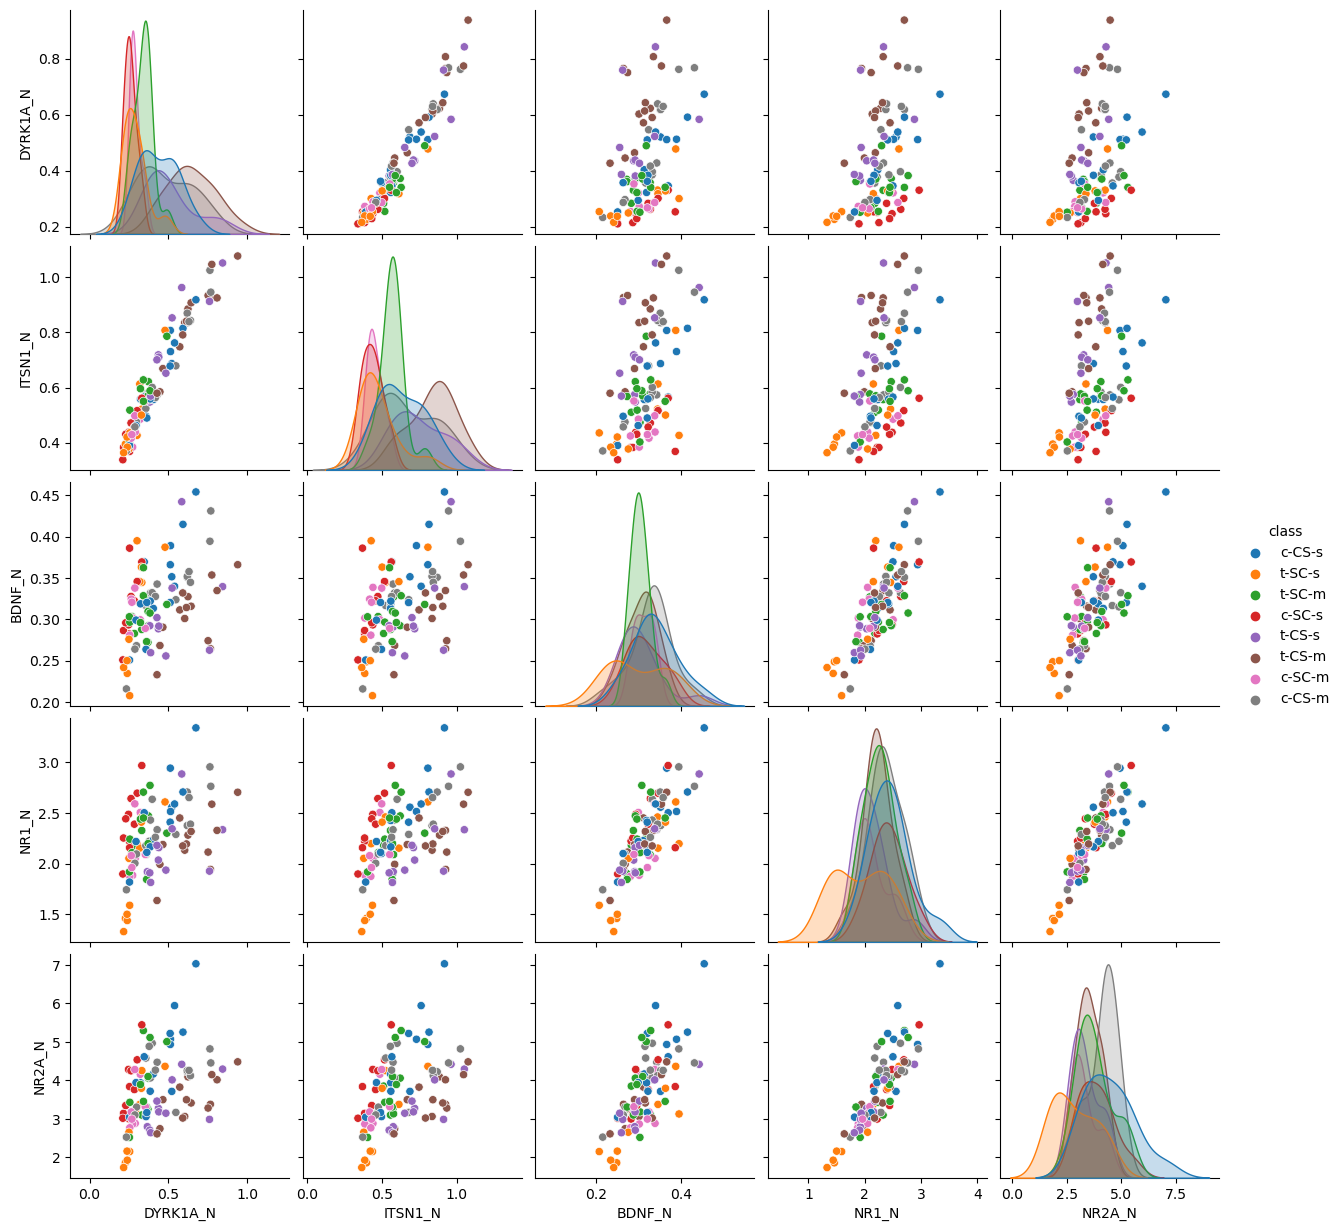

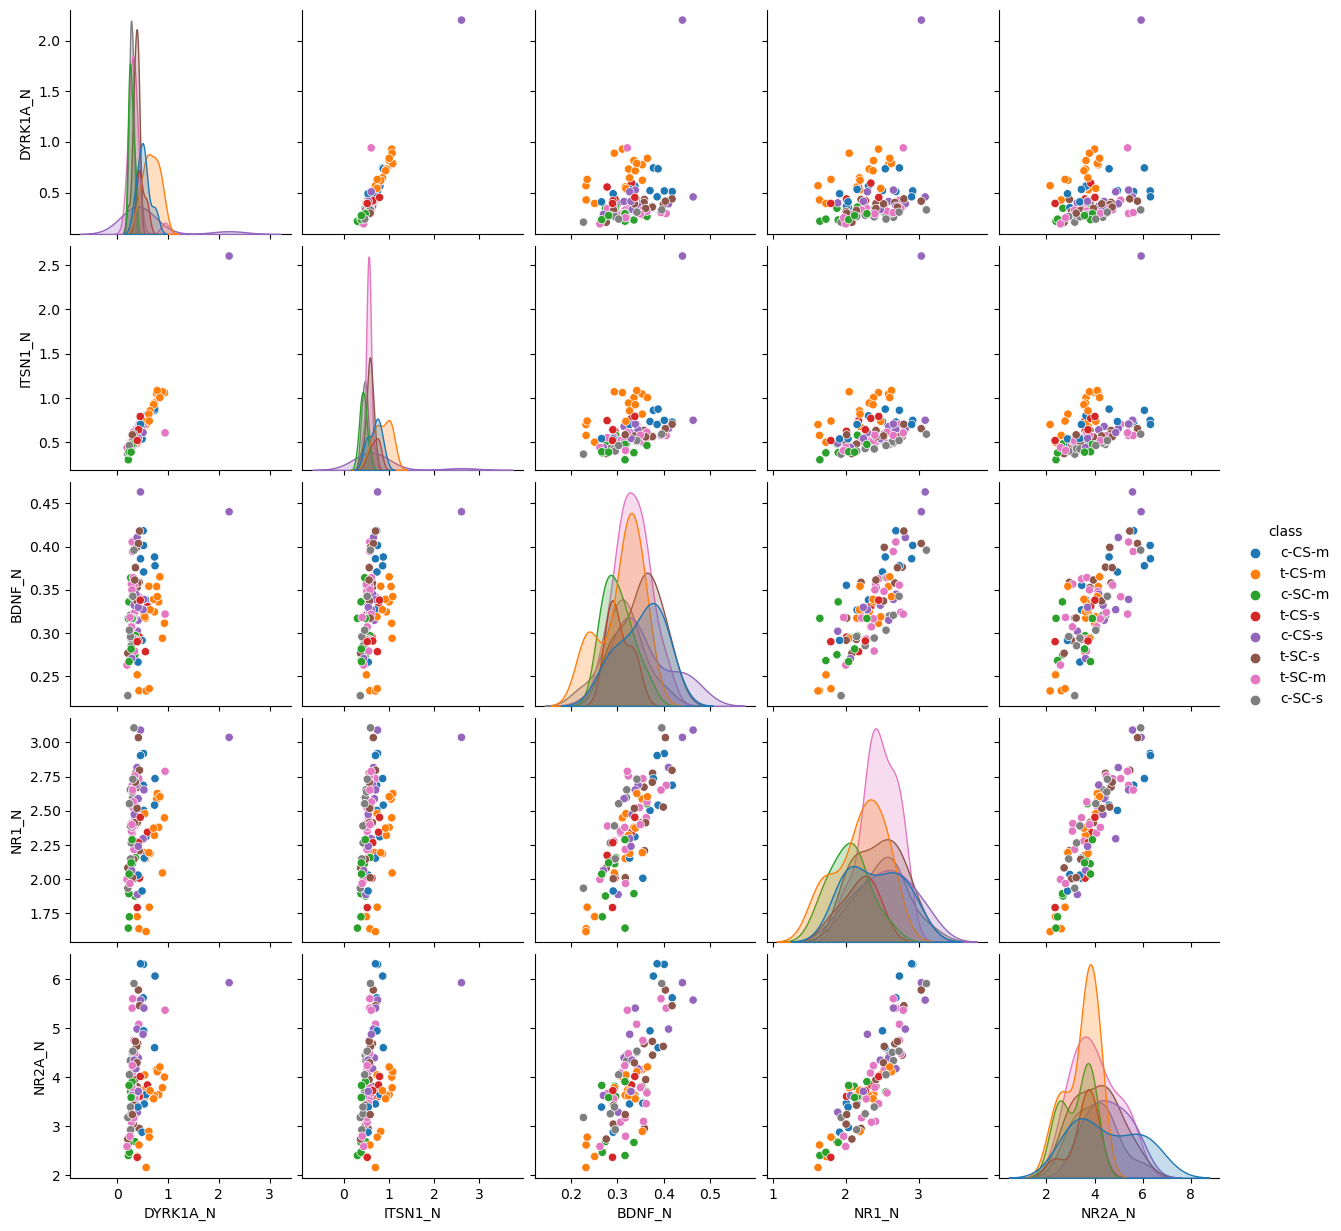

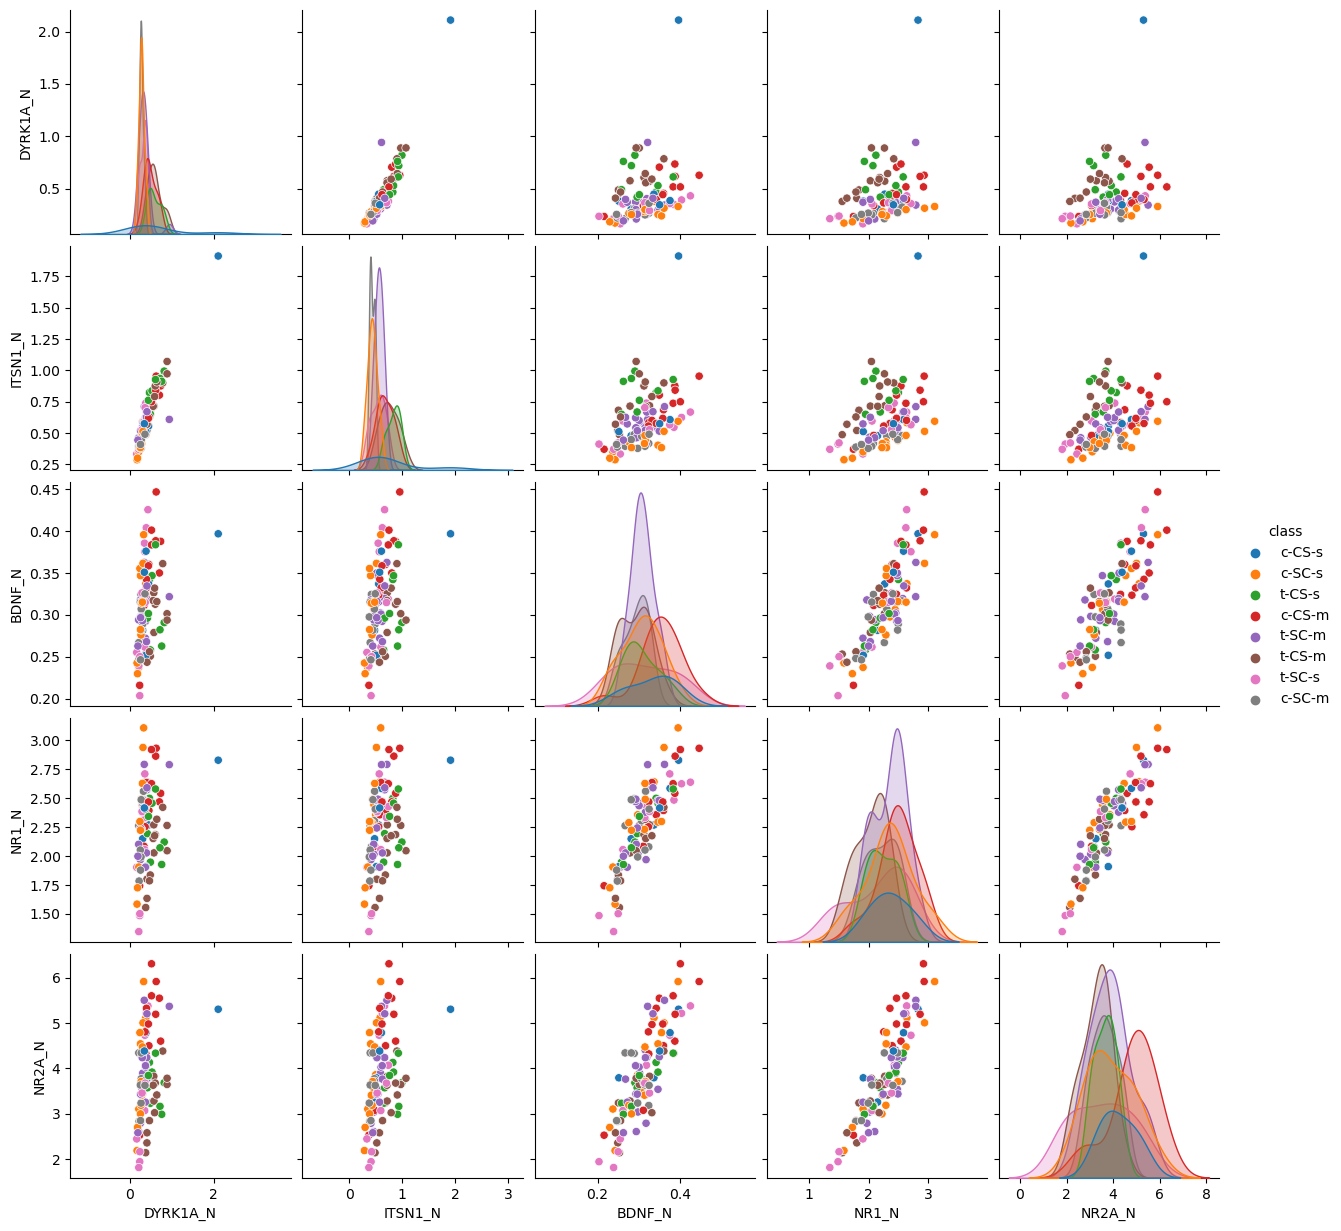

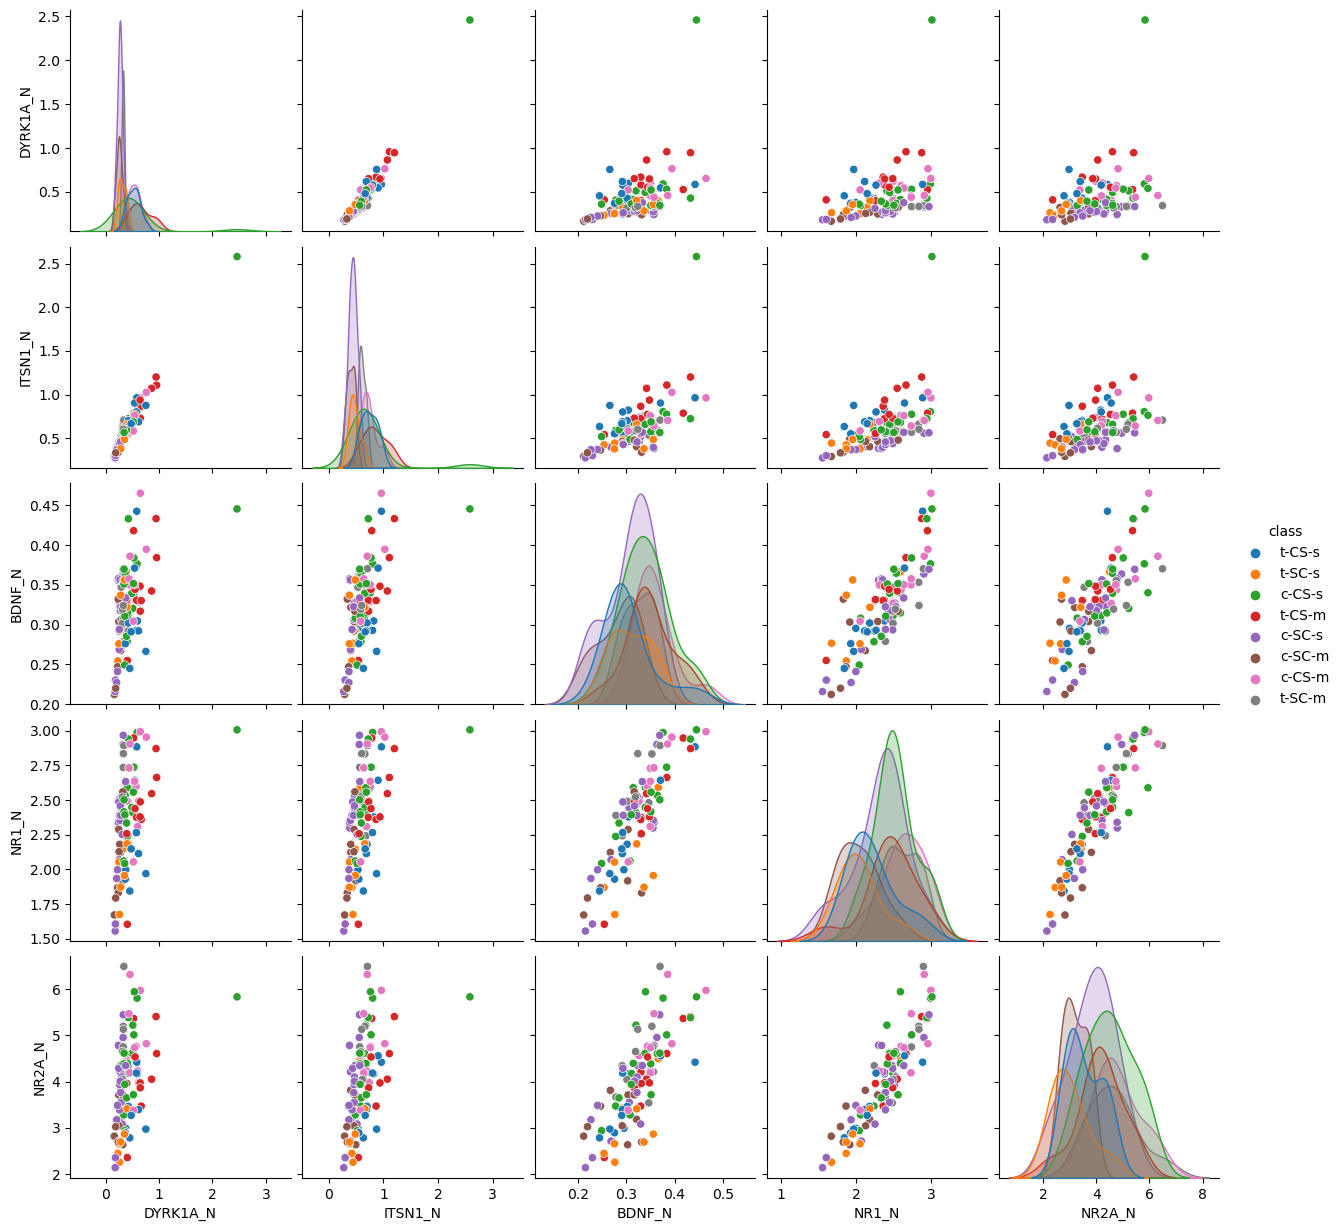

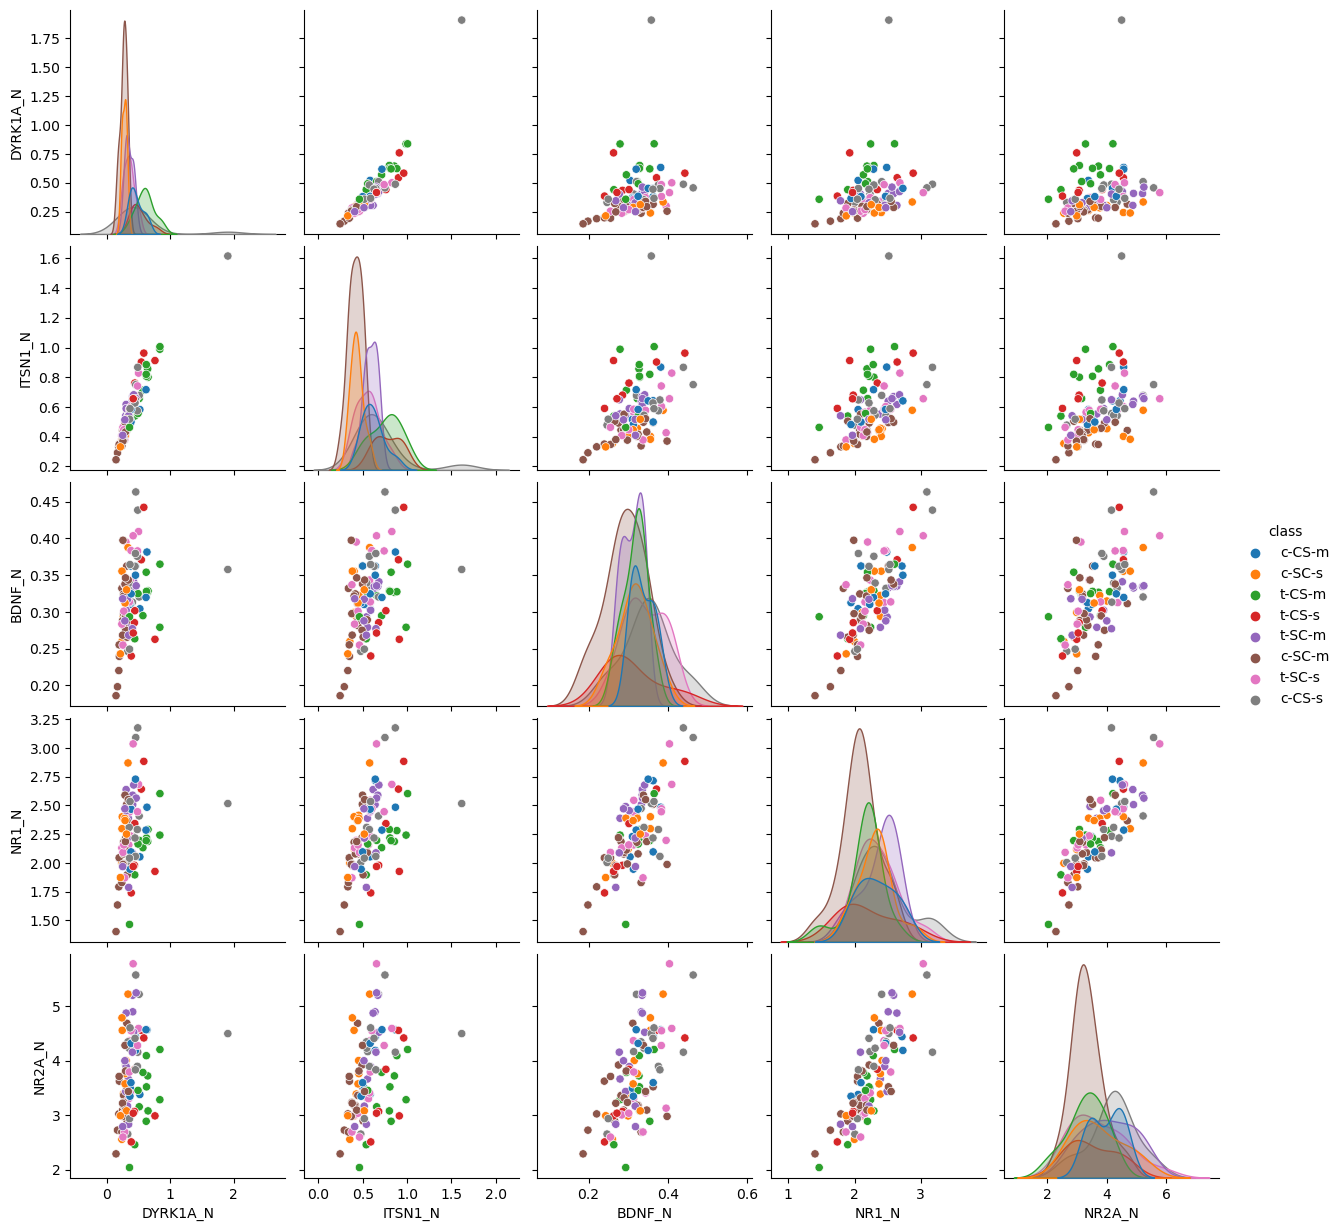

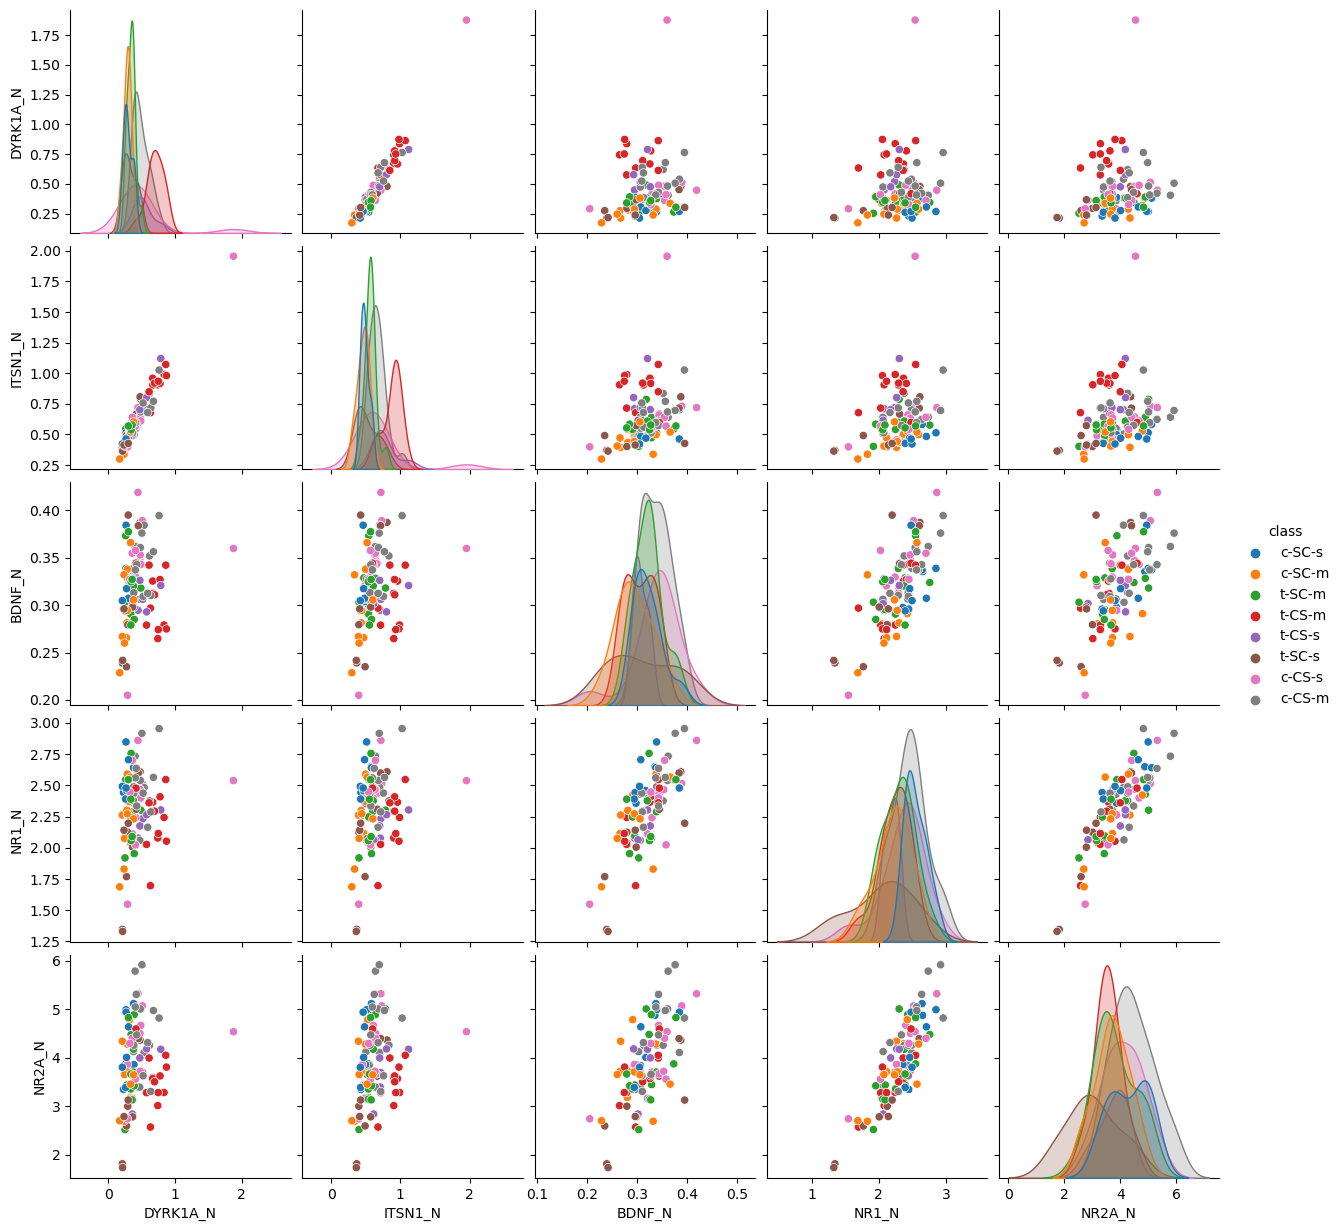

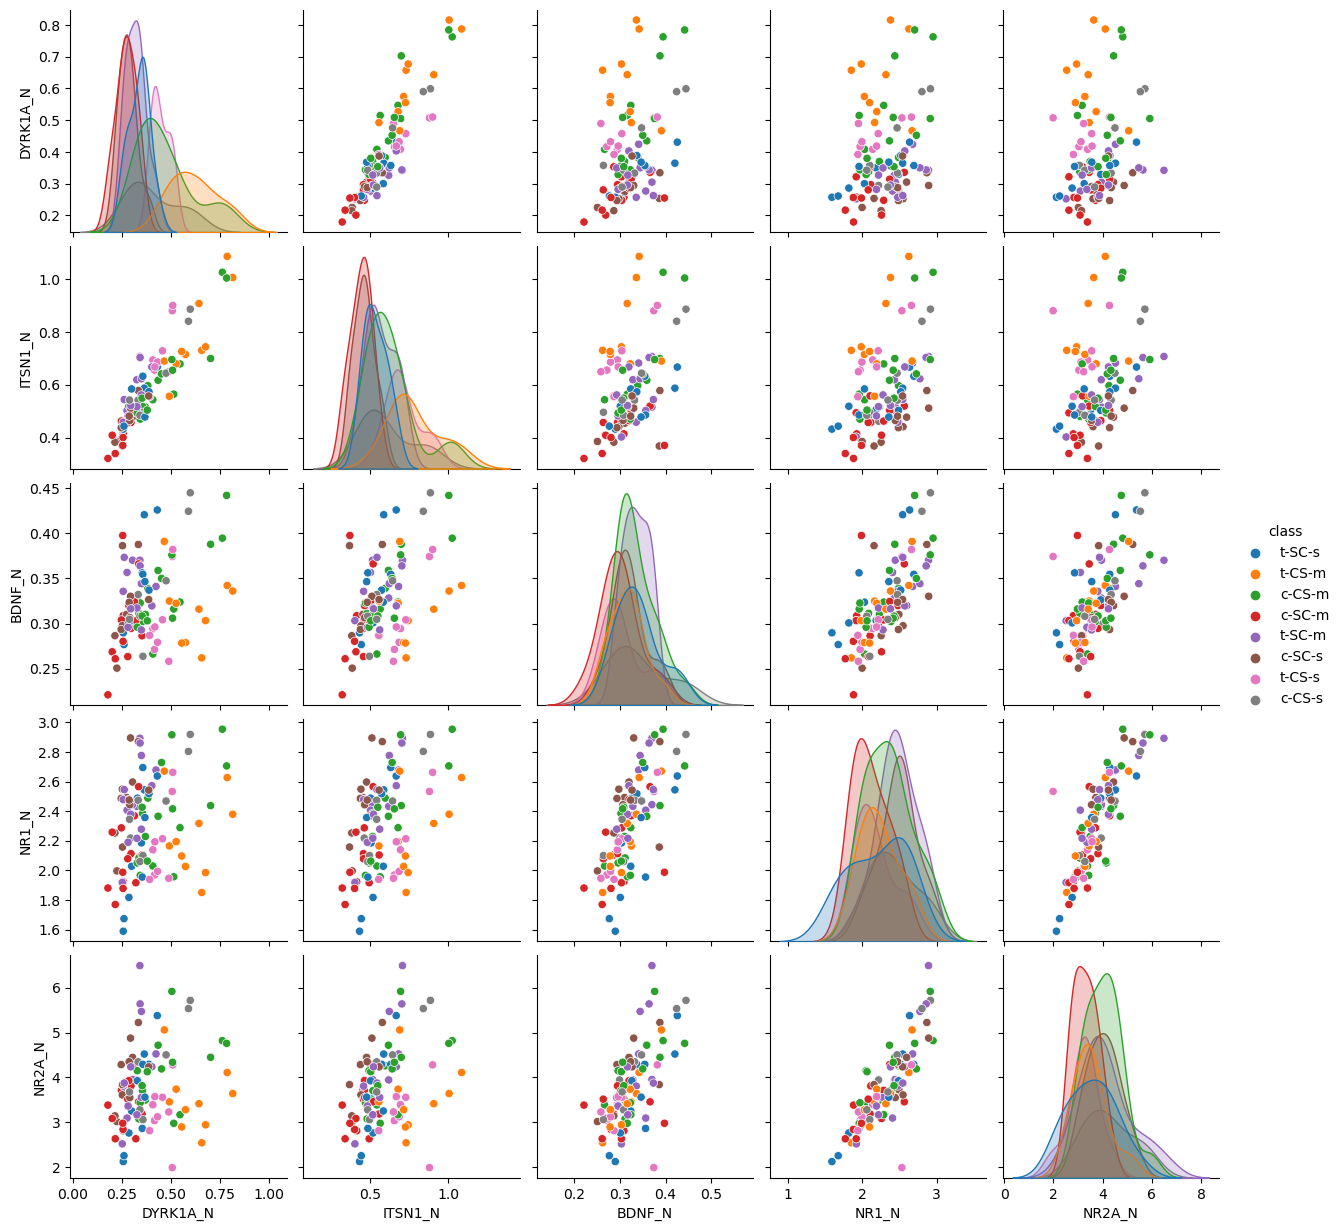

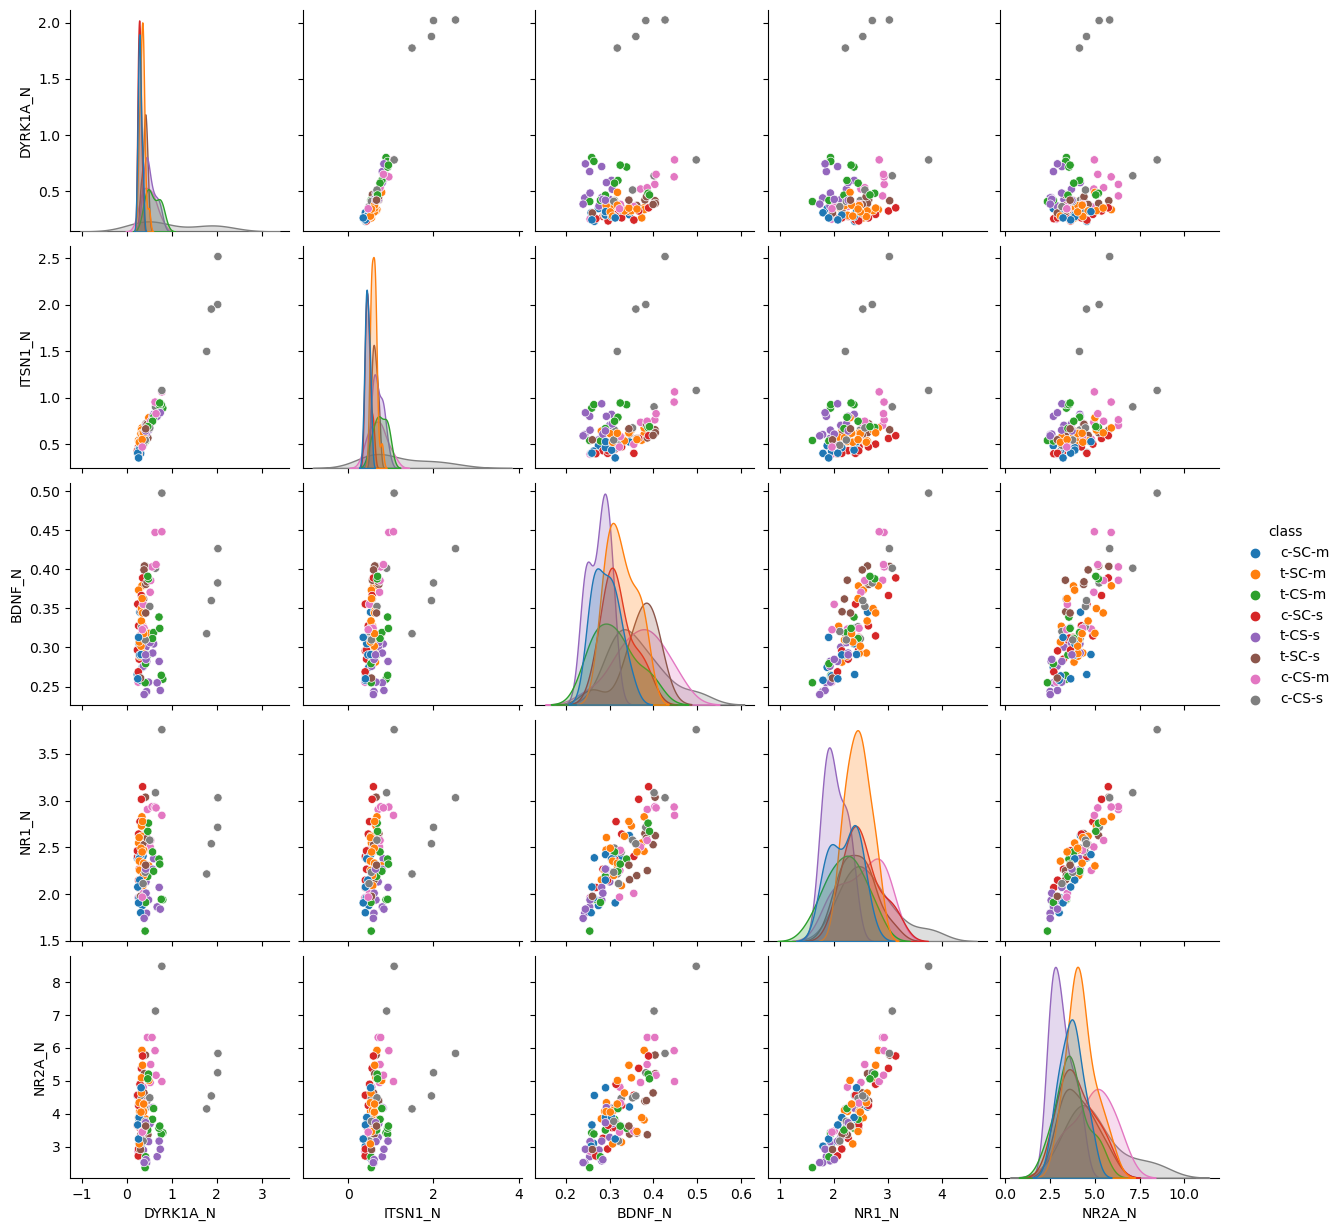

In [12]:
# Select a few columns for pairplot visualization
selected_columns = data.columns[1:6]  # Selecting 5 columns for simplicity

# Create pairplots for 10 random subsamples
for i in range(10):
    subsample = data.sample(n=100)
    sns.pairplot(subsample, vars=selected_columns, hue='class')
    plt.show()

### Clustermap

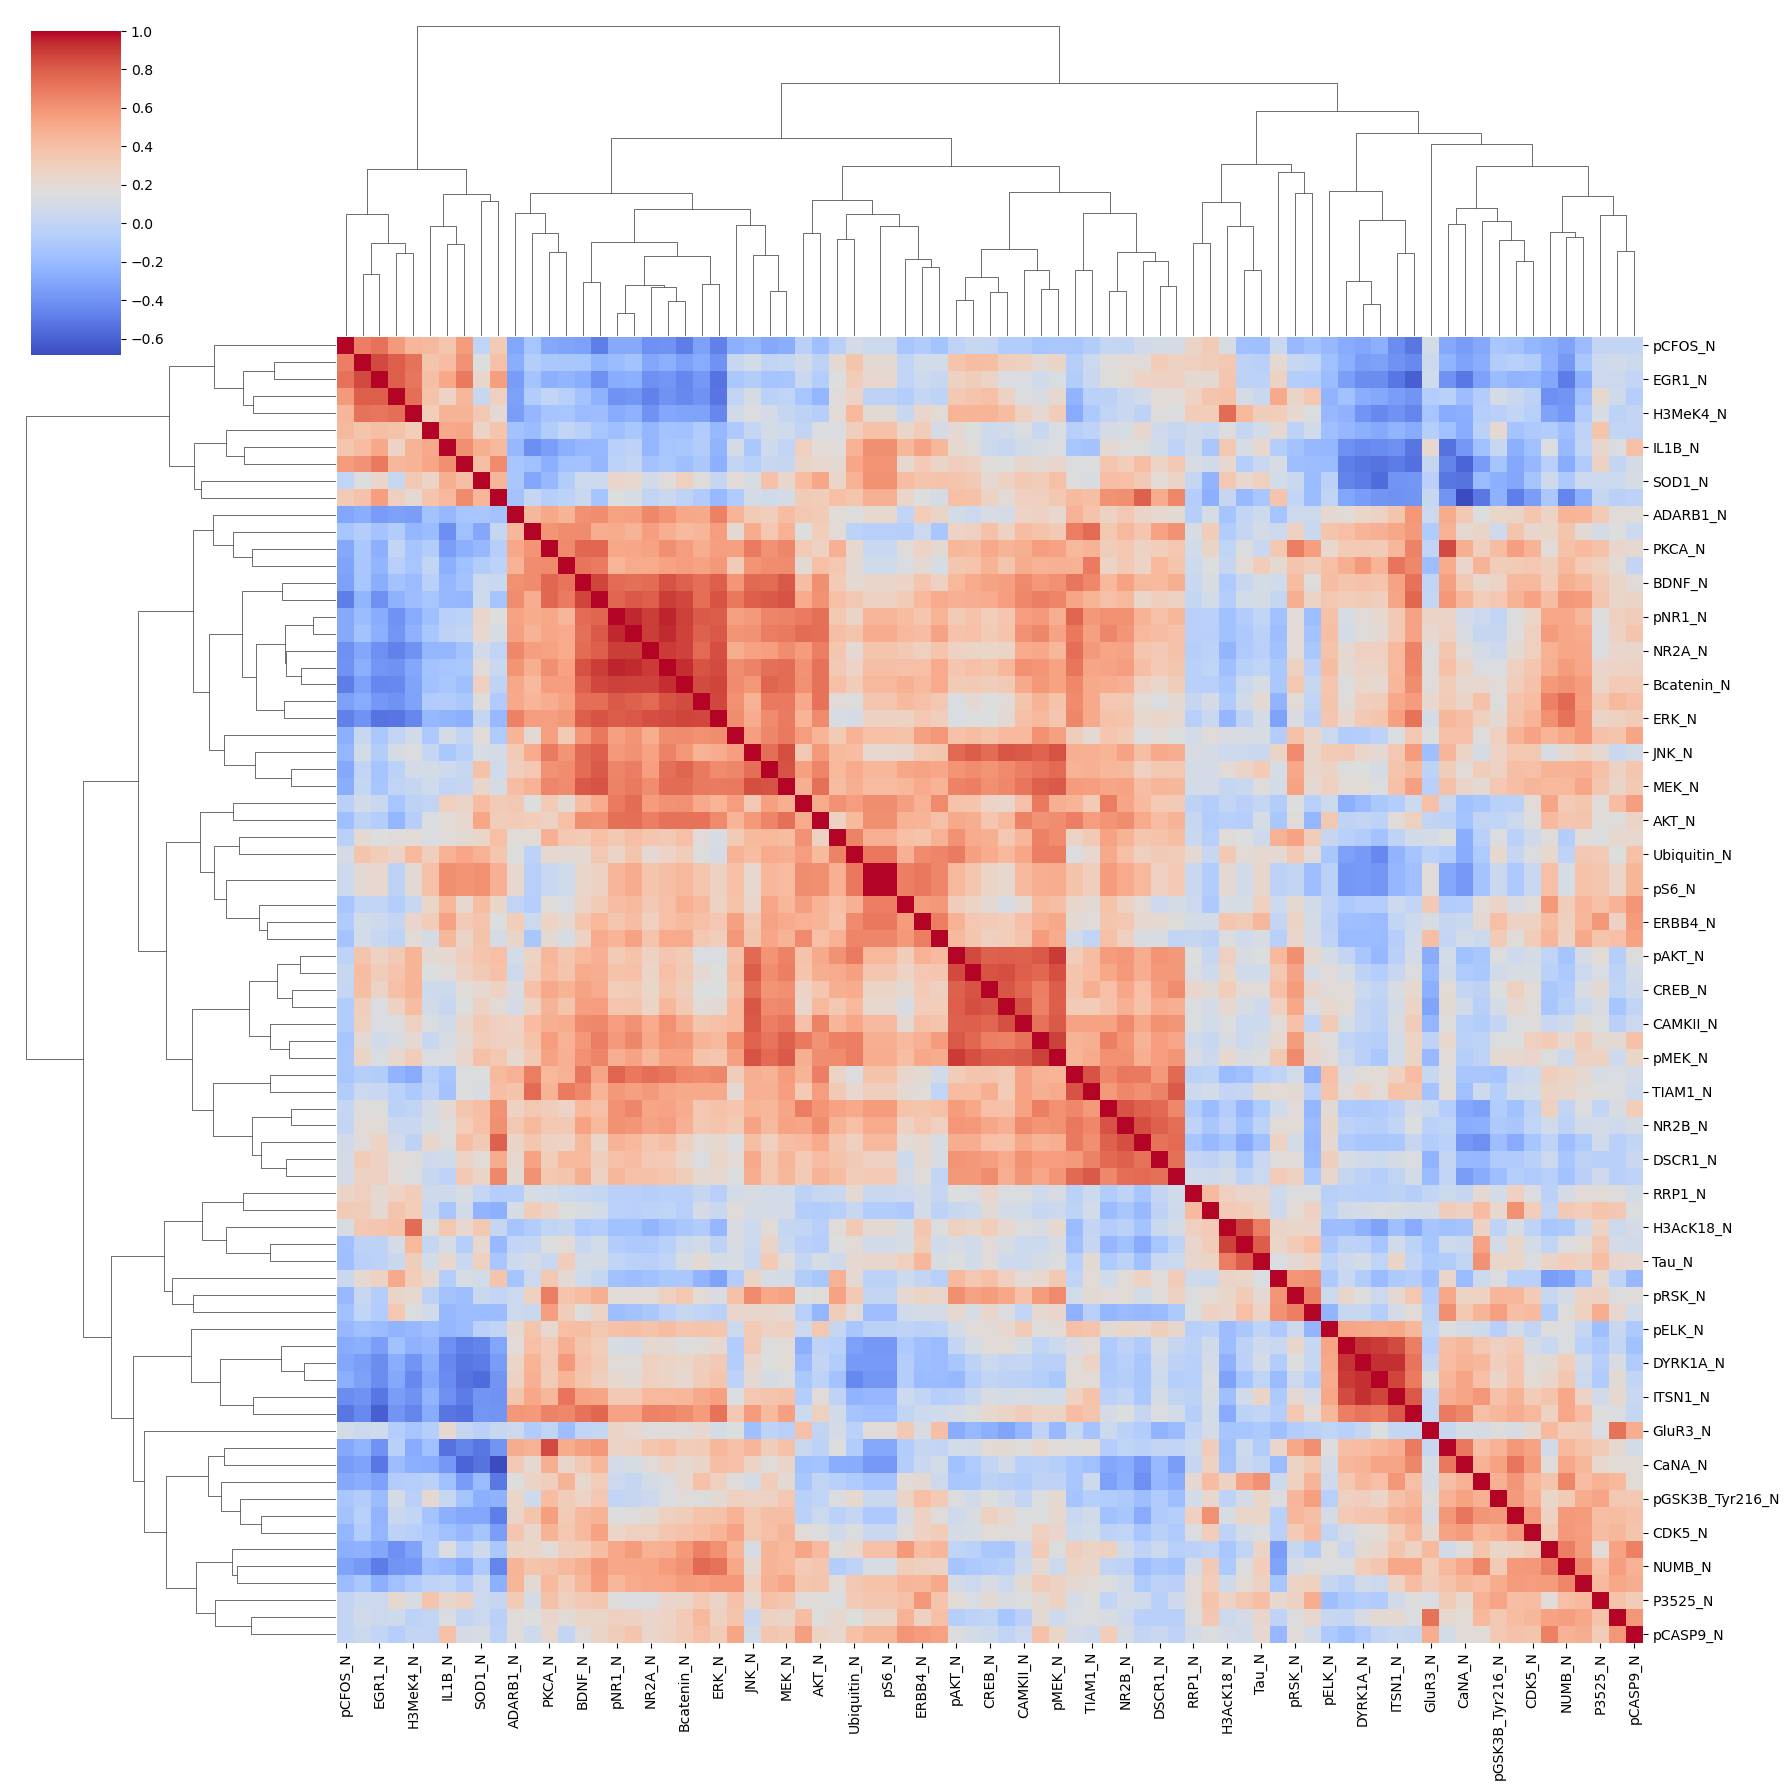

In [14]:
# Using seaborn's clustermap to explore variable relationships
sns.clustermap(data.iloc[:,1:78].dropna().corr(), figsize=(18, 18), cmap='coolwarm')
plt.show()

## SVM Modeling

### Data Preprocessing

In [17]:
# Separate numeric and categorical columns
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

# Filling missing values in numeric columns with their respective median values
numeric_data = numeric_data.fillna(numeric_data.median())

# For categorical data, let's fill missing values with the mode
for column in categorical_data.columns:
    categorical_data[column] = categorical_data[column].fillna(categorical_data[column].mode()[0])

# Re-combine the numeric and categorical columns
data_filled = pd.concat([numeric_data, categorical_data], axis=1)

# Encoding categorical variables using 'category' datatype and 'cat.codes'
for column in ['Genotype', 'Treatment', 'Behavior', 'class']:
    data_filled[column] = data_filled[column].astype('category').cat.codes

# Separating features and target
X = data_filled.drop(['MouseID', 'class'], axis=1)
y = data_filled['class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training the SVM

In [19]:
# Initialize and train the SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[47  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0]
 [ 0  0 42  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0]
 [ 0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0 38  0]
 [ 0  0  0  0  0  0  0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        49
           2       0.98      1.00      0.99        42
           3       1.00      0.98      0.99        44
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        38
           7       1.00      1.00      1.00        40

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324



## Performance Tuning Using GridSearch

In [21]:
# Setting the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}

# Creating a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters found: ", grid.best_params_)
print("Best score: ", grid.best_score_)

# Predicting with the best estimator
grid_predictions = grid.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.